In [66]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: WANDB_SILENT=true


In [67]:
import math
import torch
from torchvision.transforms import Resize
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure, LearnedPerceptualImagePatchSimilarity
import utils
from models import UNet, SkipNet, ProgNet
from denoisers import DIP, DIP_MWV, DIP_TV, DDIP, GaussianBlur, SelfDIP, DDIP_MWV, DDIP_P, DIP_P

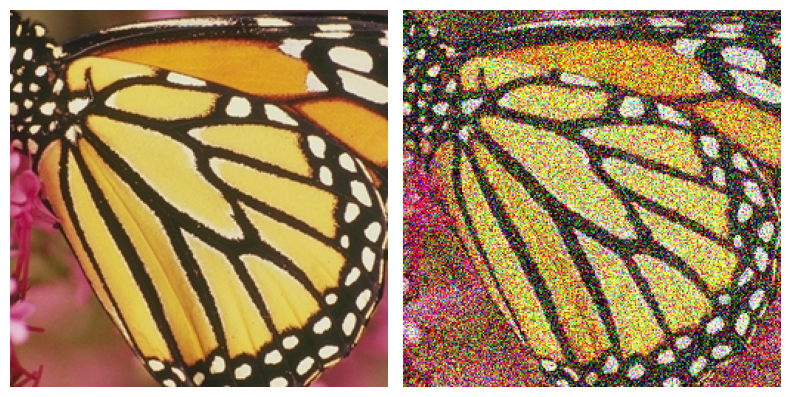

In [68]:
# clean = utils.load_celeba(1)
# clean = utils.load_images('./data/CBSD68/', Resize((256, 256)))[:30]
# clean = utils.load_images('./data/Set14/', Resize((256, 256)))
clean = utils.load_image("./data/set5/butterfly.png")
noisy = torch.stack([utils.get_noisy_image(img, 10) for img in clean])

utils.plot_row([clean[0], noisy[0]])

In [ ]:
def cos(step, start=0, end=1):
    if step < start:
        return 0
    
    if step > end:
        return 1
    
    step = (step - start) / (end - start)
    return math.cos((math.pi / 2) * (1 - step))**2

/Users/jmaen/Code/zero-shot-das-denoising/.venv/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.l

Running: 0 | DDIP Prog | ProgNet (gradual)
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000001
0.0
0.2
0.4
0.6000000000000

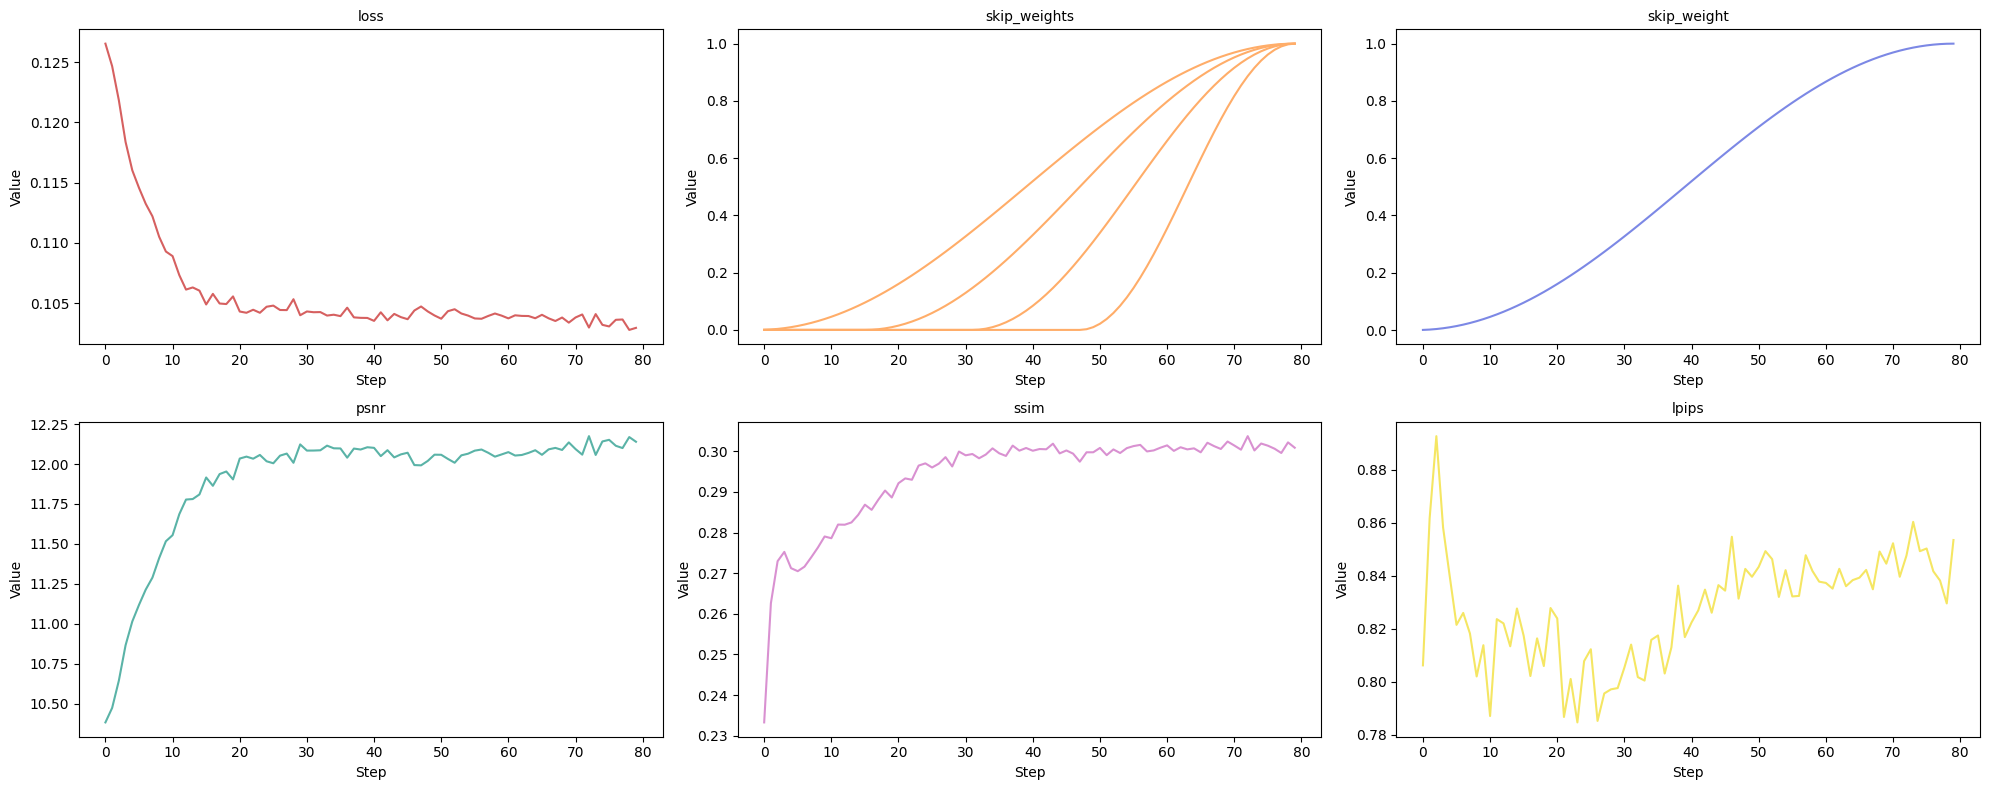

Summary: {'runtime': '00:00:05', 'psnr': 12.139810562133789, 'ssim': 0.3008739948272705, 'lpips': 0.8534634113311768}



In [70]:
skipnet_none = SkipNet(3, [8, 16, 32, 64, 128], [0, 0, 0, 0, 0], label="none")
skipnet_full = SkipNet(3, [8, 16, 32, 64, 128], [4, 4, 4, 4, 4], label="full")
skipnet_late = SkipNet(3, [8, 16, 32, 64, 128], [0, 0, 0, 4, 4], label="late")
skipnet_early = SkipNet(3, [8, 16, 32, 64, 128], [4, 4, 0, 0, 0], label="early")
unet = UNet(hidden_ch=8, n_layers=5)
prognet_fade = ProgNet(label="fade")
prognet_full = ProgNet(skip_schedules=[lambda x: 1 for _ in range(4)], label="full")
prognet_gradual = ProgNet(skip_schedules=[lambda x, i=i: cos(x, 0 + 0.2*i) for i in range(4)], label="gradual")
prognet_step = ProgNet(skip_schedules=[lambda x, i=i: cos(x, 0 + 0.2*i, 0.001) for i in range(4)], label="step")

# denoisers = [DIP_MWV(skipnet_late), DDIP_P(prognet_full), DDIP_P(prognet_fade), DDIP_P(prognet_gradual), DDIP_P(prognet_step)]
denoisers = [DDIP_P(prognet_gradual)]

results = {}
for denoiser in denoisers:
    outputs = []
    for i, (x_hat, x) in enumerate(zip(noisy, clean)):
        options = {
            "mode": "local",
            "metrics": ["psnr", "ssim", "lpips"],
            "config": {
                "project": "zero-shot-das-denoising",
                "entity": "jmaen-team", 
                "group": "prognet2",
                "dataset": "set14-10",
                "id": i,
            }
        }
        output = denoiser.denoise(x_hat.unsqueeze(0), x.unsqueeze(0), options)
        output = output.detach().cpu()
        outputs.append(output)

    results[denoiser.key()] = torch.cat(outputs)

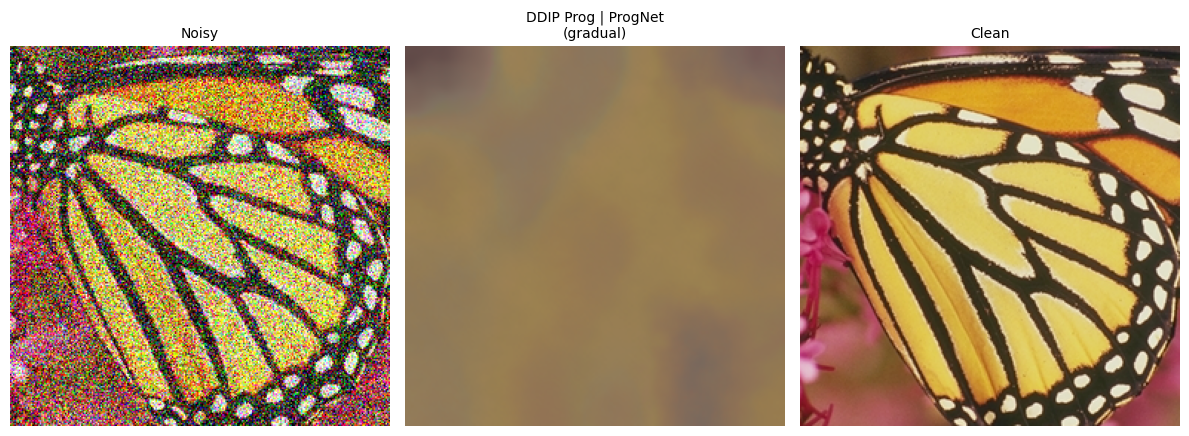

In [71]:
for result in zip(noisy, *results.values(), clean):
    utils.plot_row(result, ["Noisy", *list(results.keys()), "Clean"])

In [72]:
metrics = {
    "PSNR": PeakSignalNoiseRatio(reduction=None, data_range=1, dim=[1, 2, 3]),
    "SSIM": StructuralSimilarityIndexMeasure(reduction=None, data_range=1),
    "LPIPS": LearnedPerceptualImagePatchSimilarity(),
}

for key, metric in metrics.items():
	print(key)
	print("----------")
	print(f"Noisy:".ljust(30), f"{metric(noisy, clean).mean()}")
	for name, xs in results.items():
		s = metric(xs, clean)
		print(f"{name}:".ljust(30), f"{s.mean()}\t{s.tolist()}")
	print("\n")

PSNR
----------
Noisy:                         11.814109802246094
DDIP Prog | ProgNet (gradual): 12.242603302001953	12.242603302001953


SSIM
----------
Noisy:                         0.22269873321056366
DDIP Prog | ProgNet (gradual): 0.30300939083099365	0.30300939083099365


LPIPS
----------
Noisy:                         0.7070518732070923
DDIP Prog | ProgNet (gradual): 0.8534634113311768	0.8534634113311768


